In [ ]:
import pandas as pd
import numpy as np 
from scipy import stats
import warnings
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
train = pd.read_csv("../../data/combined/multi_class_kaggle/train.csv")
test = pd.read_csv("../../data/combined/multi_class_kaggle/test.csv")

In [3]:
train.head()

,timestamp,ax,ay,az,wx,wy,wz,latitude,longitude,speed,roadQuality,source_folder
0,1.577219e+09,0.340007,0.177560,9.828766,0.000761,-0.001328,0.002563,-27.717841,-51.098865,0.009128,0,PVS 1
1,1.577219e+09,0.323846,0.156611,9.771904,0.002492,0.000136,0.001365,-27.717841,-51.098865,0.009128,0,PVS 1
2,1.577219e+09,0.342999,0.206889,9.848519,0.000628,0.001468,0.000566,-27.717841,-51.098865,0.009128,0,PVS 1
3,1.577219e+09,0.344196,0.145837,9.815000,-0.002036,0.003865,0.001631,-27.717841,-51.098865,0.009128,0,PVS 1
4,1.577219e+09,0.313072,0.142246,9.843730,-0.003367,-0.001728,-0.001831,-27.717841,-51.098865,0.009128,0,PVS 1


In [4]:
counts = train['roadQuality'].value_counts()
percentages = train['roadQuality'].value_counts(normalize=True) * 100

imbalance_df = pd.DataFrame({
    'Count': counts,
    'Percentage': percentages
})

print(imbalance_df)


             Count  Percentage
roadQuality                   
0            28089   40.822288
3            19802   28.778630
2            19721   28.660912
1             1196    1.738170


we can see the number of 1 lables are very low as compared to the rest so we will have to use class weights, i.e., peanilise the model for predicting a wrong 1 then predicting the rest 

we will use the features ax,ay,az,wx,wy,wz,speed to predict roadQuality<br>
model structure i would use is:<br>
create window of 20 rows with step size 10 (50% overlap)<br>
so the final shape of data would look like (samples, 20, 7)<br>
and the convolution used here would be of 1d, since the 7 features are the channels here (the RGB in image context) and it will stride over the window, since the window here is 1d the filter will be of 1d, hence 1d CNN is being used <br>

converting the data into the desired windows 

In [5]:
def create_windows(df, window_size=20, step_size=10):
    """
    Converts a dataframe into windows for the Hybrid Model.
    
    Args:
        df: The dataframe containing sensor data and 'roadQuality' label.
        window_size: Number of samples per window (20 samples @ 10Hz = 2 seconds).
        step_size: Stride/Overlap (10 samples = 50% overlap).
        
    Returns:
        X_raw: The raw sensor data for the CNN (shape: N, 20, 7)
        X_stats: The statistical features for the Dense layer (shape: N, features)
        y: The labels (shape: N, )
    """
    
    # 1. DEFINING THE COLUMNS 
    # ------------------------------------------------------------------
    feature_cols = [
        'ax', 'ay', 'az',   # Accelerometer
        'wx', 'wy', 'wz', # Gyroscope
        'speed'                       # GPS Speed
    ]
    label_col = 'roadQuality'
    # ------------------------------------------------------------------

    X_raw_list = []
    X_stats_list = []
    y_list = []

    # Loop through the data using a sliding window
    # We stop when i + window_size exceeds the dataframe length
    for i in range(0, len(df) - window_size + 1, step_size):
        
        # Extract the window slice
        window = df.iloc[i : i + window_size]
        
        # --- PART A: LABELS ---
        # We take the MODE (most frequent label) of the window.
        # If a window is 60% "Bad" and 40% "Good", we label it "Bad".
        labels = window[label_col].values
        mode_label = stats.mode(labels)[0]
        # Note: If you get a scalar error, use: stats.mode(labels, keepdims=True)[0][0]
        
        # Skip windows that are majority "-1" (Unlabeled data)
        if mode_label == -1:
            continue

        # --- PART B: RAW DATA (For CNN) ---
        # Get the raw 20x7 matrix
        raw_data = window[feature_cols].values
        X_raw_list.append(raw_data)
        
        # --- PART C: STATISTICAL FEATURES (For Feature Engineering Head) ---
        # We calculate stats for EACH column in the window
        # Features: Mean, Std Dev, RMS, Peak-to-Peak, skewness, kurtosis
        # didn't use Min, Max, energy, jerk and zero crossing count (from the sypnosis) because these features are irralavant for one value for the complete row,
        # more complex form of these features will get learned by the raw data CNN
        
        stats_row = []
        for col in feature_cols:
            series = window[col].values
            
            # 1. Mean
            stats_row.append(np.mean(series))
            # 2. Standard Deviation
            stats_row.append(np.std(series))
            # 3. RMS (Root Mean Square) - Measure of energy/intensity
            stats_row.append(np.sqrt(np.mean(series**2)))
            # 4. Range (Peak-to-Peak) - Measure of impact
            stats_row.append(np.max(series) - np.min(series))
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", RuntimeWarning) #while running the code there is warning that variance is almost zero for some data so skew and kurt are irrelevant... it was flodding the output so i ignored it 
                # 5. skewness: differentiates between an dip and a bump
                stats_row.append(stats.skew(series, bias=False))
                # 6. kurtosis: will highlight if there is a dip on a smooth road (differentiates an smooth road with a big aah pothole in middle and a consatly bumpy road)
                stats_row.append(stats.kurtosis(series, fisher=True, bias=False))
                
        X_stats_list.append(stats_row)
        y_list.append(mode_label)

    # Convert to efficient Numpy Arrays
    X_raw = np.array(X_raw_list)
    X_stats = np.array(X_stats_list)
    y = np.array(y_list)
    
    return X_raw, X_stats, y

# =============================================================================
# USAGE
# =============================================================================

# 1. Run the function
train = train.dropna() #ensuring no null rows
X_train_raw, X_train_stats, y_train = create_windows(train, window_size=20, step_size=10)

# 2. Check the shapes (Sanity Check)
print("-"*30)
print ("train")
print(f"Original Rows: {len(train)}")
print(f"Generated Windows: {len(y_train)}")
print("-" * 30)
print(f"X_raw Shape (CNN Input):   {X_train_raw.shape}")   # Should be (N, 20, 7)
print(f"X_stats Shape (MLP Input): {X_train_stats.shape}") # Should be (N, 42) -> 7 cols * 6 stats
print(f"y Shape (Labels):          {y_train.shape}")
print("YAYYYY WINDOWING IS SUCCESSFULLLLLL !!!!!!!!!!")

test = test.dropna() #ensuring no null rows
X_test_raw, X_test_stats, y_test = create_windows(test, window_size=20, step_size=10)

print("-"*30)
print ("test")
print(f"Original Rows: {len(test)}")
print(f"Generated Windows: {len(y_test)}")
print("-" * 30)
print(f"X_raw Shape (CNN Input):   {X_test_raw.shape}")   # Should be (N, 20, 7)
print(f"X_stats Shape (MLP Input): {X_test_stats.shape}") # Should be (N, 42) -> 7 cols * 6 stats
print(f"y Shape (Labels):          {y_test.shape}")
print("YAYYYY WINDOWING IS SUCCESSFULLLLLL !!!!!!!!!!")




------------------------------
train
Original Rows: 68808
Generated Windows: 6879
------------------------------
X_raw Shape (CNN Input):   (6879, 20, 7)
X_stats Shape (MLP Input): (6879, 42)
y Shape (Labels):          (6879,)
YAYYYY WINDOWING IS SUCCESSFULLLLLL !!!!!!!!!!
------------------------------
test
Original Rows: 32082
Generated Windows: 3207
------------------------------
X_raw Shape (CNN Input):   (3207, 20, 7)
X_stats Shape (MLP Input): (3207, 42)
y Shape (Labels):          (3207,)
YAYYYY WINDOWING IS SUCCESSFULLLLLL !!!!!!!!!!


now we build the hybrid CNN

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 raw_sensor_input (InputLayer)  [(None, 20, 7)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 20, 32)       704         ['raw_sensor_input[0][0]']       
                                                                                                  
 batch_normalization (BatchNorm  (None, 20, 32)      128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 10, 32)       0           ['batch_normalization[0][0]']

c:\Users\nishk\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\nishk\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\nishk\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


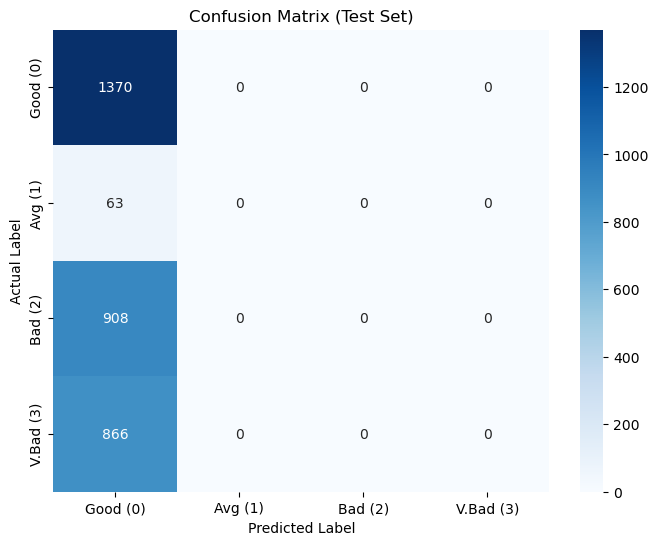

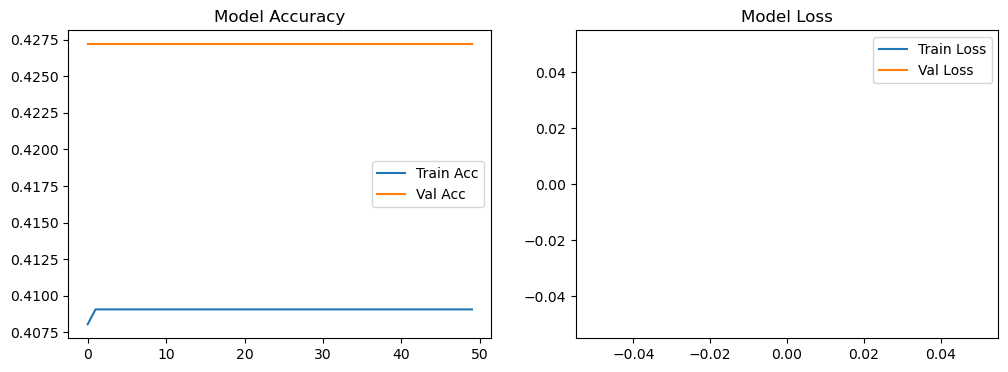

Model saved successfully as 'road_quality_hybrid_model.h5'


In [6]:

# =============================================================================
# 1. DEFINE THE HYBRID ARCHITECTURE
# =============================================================================
def build_hybrid_model(input_shape_raw, input_shape_feat, num_classes=4):
    """
    Constructs a two-headed model:
    - Head A: 1D CNN for raw sensor time-series (finding patterns/shapes)
    - Head B: Dense Network for statistical features (physics/intensity)
    """
    
    # --- BRANCH A: Raw Sensor Data (1D CNN) ---
    input_raw = Input(shape=input_shape_raw, name="raw_sensor_input")
    
    # Layer 1: Capture fine-grained vibrations
    x = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(input_raw)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    
    # Layer 2: Capture larger events (potholes/bumps)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    
    # Flatten to a vector
    x = GlobalAveragePooling1D()(x)
    
    # --- BRANCH B: Statistical Features (MLP) ---
    input_feat = Input(shape=input_shape_feat, name="stat_features_input")
    
    # Dense layers to process the 42 math features
    y = Dense(32, activation='relu')(input_feat)
    y = BatchNormalization()(y)
    y = Dense(16, activation='relu')(y)
    
    # --- MERGE THE BRANCHES ---
    combined = Concatenate()([x, y])
    
    # Interpretation Block
    z = Dense(64, activation='relu')(combined)
    z = Dropout(0.5)(z) # High dropout to prevent overfitting on the small classes
    
    # Output Layer (Softmax for 0, 1, 2, 3)
    output = Dense(num_classes, activation='softmax')(z)
    
    # Compile Model Object
    model = Model(inputs=[input_raw, input_feat], outputs=output)
    return model

# =============================================================================
# 2. SETUP & COMPILE
# =============================================================================

# Build the model
# Shapes match your print output: (20, 7) and (42,)
model = build_hybrid_model(
    input_shape_raw=(20, 7), 
    input_shape_feat=(42,),
    num_classes=4
)

model.summary()

# Calculate Class Weights (CRITICAL for your imbalance)
# This forces the model to pay attention to Class 1 (Average) even though it's rare.
class_weights_vals = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights_vals))

print(f"\nAuto-Calculated Class Weights: {class_weights_dict}")
# Expect Class 1 weight to be much higher (e.g., > 10.0)

# Compile
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# =============================================================================
# 3. TRAIN THE MODEL
# =============================================================================
print("\nStarting Training...")

history = model.fit(
    # Inputs must be a list: [Raw_Data, Stats_Data]
    x=[X_train_raw, X_train_stats],
    y=y_train,
    
    # Validation Data (also list)
    validation_data=([X_test_raw, X_test_stats], y_test),
    
    epochs=50,             # Adjust if it converges sooner
    batch_size=32,         # Standard batch size
    class_weight=class_weights_dict, # Apply the imbalance fix
    verbose=1
)

# =============================================================================
# 4. EVALUATE & VISUALIZE
# =============================================================================

# Get predictions
print("\nGenerating Predictions...")
y_pred_probs = model.predict([X_test_raw, X_test_stats])
y_pred = np.argmax(y_pred_probs, axis=1)

# 1. Classification Report (Precision/Recall/F1)
target_names = ['Good (0)', 'Avg (1)', 'Bad (2)', 'V.Bad (3)']
print("\n--- CLASSIFICATION REPORT ---")
# Only include labels that actually exist in y_test
unique_labels = np.unique(y_test)
print(classification_report(y_test, y_pred, labels=unique_labels, target_names=[target_names[i] for i in unique_labels]))

# 2. Confusion Matrix Plot
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[target_names[i] for i in unique_labels],
            yticklabels=[target_names[i] for i in unique_labels])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix (Test Set)')
plt.show()

# 3. Training Curves (Loss & Accuracy)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

# =============================================================================
# 5. SAVE MODEL (Ready for TinyML conversion later!)
# =============================================================================
model.save("road_quality_hybrid_model.h5")
print("Model saved successfully as 'road_quality_hybrid_model.h5'")